-C] Probablemente se hubieran mejorado los resultados si se hubieran utilizado varios modelos a modo de ensemble, por ejemplo separando por ciudad. -D] Se echan en falta mucho mejores interpretaciones, discusiones y comparativas de los resultados de las predicciones."

#### Inicio

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import json
import csv
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from scipy.stats import uniform
from random import randint, random, choice
from operator import add
from functools import reduce
import numpy as np
from sklearn.model_selection import cross_val_score

In [3]:
# Conectamos con nuestro Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
seed = 42

### Descarga del Dataset

In [5]:
lista = []
datacsv_ami = './drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/csv/dataset_asturias_amieva.csv'
# datacsv_pil = './drive/MyDrive/MASTER_BIG_DATA/14_TFM/csv/dataset_asturias_piloña.csv'
# datacsv_cab = './drive/MyDrive/MASTER_BIG_DATA/14_TFM/csv/dataset_asturias_cabrales.csv'
#datacsv_ami = '/home/miguel/Documentos/MASTER_BIG_DATA/14_TFM/csv/dataset_asturias_amieva.csv'
# datacsv_pil = '/home/miguel/Documentos/MASTER_BIG_DATA/14_TFM/csv/dataset_asturias_piloña.csv'
# datacsv_cab = '/home/miguel/Documentos/MASTER_BIG_DATA/14_TFM/csv/dataset_asturias_cabrales.csv'
data_ami = pd.read_csv(datacsv_ami, delimiter=",", encoding="utf-8")
# data_pil = pd.read_csv(datacsv_pil, delimiter=",", encoding="utf-8")
# data_cab = pd.read_csv(datacsv_cab, delimiter=",", encoding="utf-8")
# lista = [data_ami, data_pil, data_cab]
# data = pd.concat(lista, ignore_index=True)

In [ ]:
# uso solo una estación
data = data_ami.copy()
#data = data.drop(columns=['caudal_m3s'])

In [ ]:
display(data.info())

In [ ]:
# Suponiendo que 'df' es tu DataFrame y 'fecha' es la columna con fechas
data['fecha'] = pd.to_datetime(data['fecha'])  # Asegurarse de que la columna es de tipo datetime

# Crear nuevas columnas con el año, mes y día
data['año'] = data['fecha'].dt.year
data['mes'] = data['fecha'].dt.month
data['día'] = data['fecha'].dt.day

In [ ]:
print(data.info())

In [ ]:
lista_numericas = data.select_dtypes(include=[np.number]).columns.to_list()
lista_numericas.remove('altura_m')

In [ ]:
train, validation = train_test_split(data, test_size=0.15, random_state=seed)

In [ ]:
train, test = train_test_split(train, test_size=0.15, random_state=seed)

In [ ]:
X_train = train.drop(columns=['altura_m'])
y_train = train['altura_m']
X_validation = validation.drop(columns=['altura_m'])
y_validation = validation['altura_m']
X_test = test.drop(columns=['altura_m'])
y_test = test['altura_m']

* convierto la variable dependiente a escala logarítmica

In [ ]:
# y_train = np.log1p(y_train)
# y_validation = np.log1p(y_validation)
# y_test = np.log1p(y_test)

### Normalizo

In [ ]:
# Normalizo el dataframe transpuesto para estudio de matriz de similitud
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()
X_train_norm = X_train[lista_numericas].copy()
X_train_norm = min_max_scaler.fit_transform(X_train_norm)
X_train_norm = pd.DataFrame(X_train_norm, columns=lista_numericas)#, index=X_train_norm.index)
y_train_norm = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
#y_train_norm = pd.DataFrame(y_train_norm)
y_train_norm = y_train_norm.ravel()

In [ ]:
display(y_train_norm)

array([0.09356725, 0.26900585, 0.30604288, ..., 0.14035088, 0.28654971,
       0.28460039])

In [ ]:
# Normalizo el dataframe transpuesto para estudio de matriz de similitud
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()
X_validation_norm = X_validation[lista_numericas].copy()
X_validation_norm = min_max_scaler.fit_transform(X_validation_norm)
X_validation_norm = pd.DataFrame(X_validation_norm, columns=lista_numericas)#, index=X_train_norm.index)
y_validation_norm = scaler_Y.fit_transform(y_validation.values.reshape(-1, 1))
#y_validation_norm = pd.DataFrame(y_validation_norm)
y_validation_norm = y_validation_norm.ravel()

In [ ]:
# Normalizo el dataframe transpuesto para estudio de matriz de similitud
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_test_norm = X_test[lista_numericas].copy()
X_test_norm = min_max_scaler.fit_transform(X_test_norm)
X_test_norm = pd.DataFrame(X_test_norm, columns=lista_numericas)#, index=X_train_norm.index)
#y_test_norm = min_max_scaler.fit_transform(y_test.values.reshape(-1, 1))
#y_test_norm = pd.DataFrame(y_test_norm)
#y_test_norm = y_test_norm.ravel()

### 1-RandomForest

#### Randomized

* Hiperparámetros

In [ ]:
# RandoForest
param_dist_RF = {
        "n_estimators": [128,256],                        # Number of trees in random forest
        "max_features": [1.0, 'sqrt'],                   # Number of features to consider at every split (1.0 is the old 'auto')
        "max_depth": [16, 12,8,None],                    # Maximum number of levels in tree
        "min_samples_split": [2, 20],                     #  Minimum number of samples required to split a node
        "min_samples_leaf": [1, 20],                      # Minimum number of samples required at each leaf node
        "bootstrap": [True, False],                       # Method of selecting samples for training each tree
        "criterion": ["squared_error", "absolute_error"],
        "random_state": [seed, ]
        }

In [ ]:
regressor_RF = RandomForestRegressor(random_state=0)
regressor_RF

RandomForestRegressor(random_state=0)

In [ ]:
rnd_regres_RF = RandomizedSearchCV(
                                estimator = regressor_RF, param_distributions = param_dist_RF,
                                n_iter = 10,
                                cv = 5,
                                random_state=seed,
                                n_jobs = -1)

# Fit the random search model
rnd_regres_RF.fit(X = X_train_norm, y = y_train_norm)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [16, 12, 8, None],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': [1, 20],
                                        'min_samples_split': [2, 20],
                                        'n_estimators': [128, 256],
                                        'random_state': [42]},
                   random_state=42)

In [ ]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

* Muestro el ranking

In [ ]:
report(rnd_regres_RF.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.932 (std: 0.005)
Parameters: {'random_state': 42, 'n_estimators': 256, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.925 (std: 0.007)
Parameters: {'random_state': 42, 'n_estimators': 256, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 1.0, 'max_depth': 8, 'criterion': 'squared_error', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.920 (std: 0.005)
Parameters: {'random_state': 42, 'n_estimators': 256, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 16, 'criterion': 'squared_error', 'bootstrap': True}

Model with rank: 4
Mean validation score: 0.917 (std: 0.011)
Parameters: {'random_state': 42, 'n_estimators': 128, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 1.0, 'max_depth': 16, 'criterion': 'squared_error', 'bootst

* Muestro mejores hy y el MAE.

In [ ]:
from sklearn.metrics import mean_absolute_error
# Mostrar los mejores parámetros encontrados
print("Mejores hiperparám:", rnd_regres_RF.best_params_)
# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_RF_regressor = rnd_regres_RF.best_estimator_
y_pred_RF = best_RF_regressor.predict(X_test_norm)
y_pred_RF = scaler_Y.inverse_transform(y_pred_RF.reshape(-1, 1))
mae_RF = mean_absolute_error(y_test, y_pred_RF)
print("MAE:", mae_RF)

Mejores hiperparám: {'random_state': 42, 'n_estimators': 256, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': False}
MAE: 0.20574706822305533


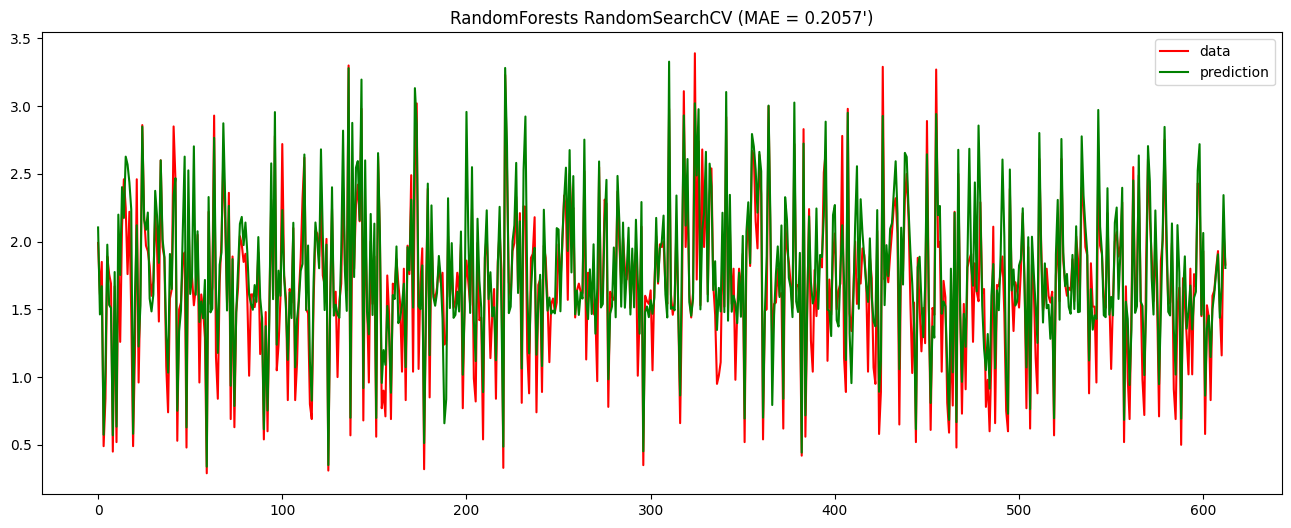

In [ ]:
# x axis for plotting
import numpy as np
xx = np.stack([i for i in range(y_test.shape[0])])
plt.figure(figsize=(16, 6))
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred_RF, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests RandomSearchCV (MAE = %6.4f')" % ( mae_RF))

plt.show()

#### GridSearch

* En esta parte ajustaré los hyperparámetro de cada algorímo obtenidos previamente hasta conseguir un MAE adecuado

* Imprimo los hyperparámetros que ha generado el proceso de Randomized

In [ ]:
print("Mejores hiperparámetros:", rnd_regres_RF.best_params_)

Mejores hiperparámetros: {'random_state': 42, 'n_estimators': 256, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'squared_error', 'bootstrap': False}


In [ ]:
# max_depth=8, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=12, random_state=0 -->19.8161
param_dist_RF = {"n_estimators": [256,], # Number of trees in random forest
              "max_features": ['sqrt', ], # Number of features to consider at every split (1.0 is the old 'auto')
              "max_depth": [None,], # Maximum number of levels in tree
              "min_samples_split": [2, ], #  Minimum number of samples required to split a node
              "min_samples_leaf": [1, ], # Minimum number of samples required at each leaf node
              "bootstrap": [False], # Method of selecting samples for training each tree
              "criterion": ['squared_error', ],
              "random_state": [seed,]
            }

In [ ]:
grid_regres_RF = GridSearchCV(estimator = regressor_RF,
                              param_grid= param_dist_RF,
                              cv=5)

# Fit the random search model
grid_regres_RF.fit(X = X_train_norm, y = y_train_norm)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'bootstrap': [False], 'criterion': ['squared_error'],
                         'max_depth': [None], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [256], 'random_state': [42]})

In [ ]:
report(grid_regres_RF.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: 0.932 (std: 0.005)
Parameters: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 256, 'random_state': 42}



In [ ]:
rgrid_regres_RF = grid_regres_RF.best_estimator_
rgrid_regres_RF

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=256,
                      random_state=42)

In [ ]:
from joblib import dump, load

In [ ]:
dump(rgrid_regres_RF, "./drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/modelos/rf_model_amieva.pkl")

In [ ]:
# Cargar desde disco
rgrid_regres_RF = load("./drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/modelos/rf_model_amieva.pkl")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Mostrar los mejores parámetros encontrados
print("Mejores hiperparám:", grid_regres_RF.best_estimator_)
# Evaluar el modelo con los mejores parámetros en el conjunto de prueba
best_RF_grdregressor = grid_regres_RF.best_estimator_
y_pred_RF = best_RF_grdregressor.predict(X_test_norm)
y_pred_RF = scaler_Y.inverse_transform(y_pred_RF.reshape(-1, 1))
mae_RF = mean_absolute_error(y_test, y_pred_RF)
mse_RF = mean_squared_error(y_test, y_pred_RF)
r2_RF = r2_score(y_test, y_pred_RF)

# Mostrar resultados
print(f"MAE: {mae_RF}")
print(f"MSE: {mse_RF}")
print(f"R²: {r2_RF}")

Mejores hiperparám: RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=256,
                      random_state=42)
MAE: 0.20574706822305533
MSE: 0.07440395047350613
R²: 0.7666364510023199


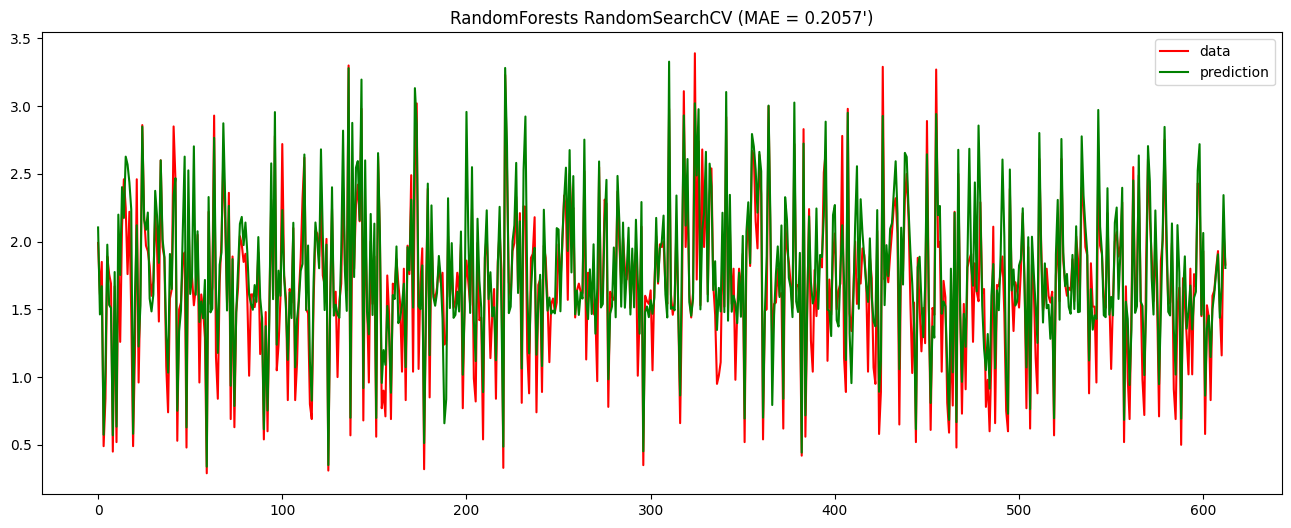

In [ ]:
# x axis for plotting
import numpy as np
xx = np.stack([i for i in range(y_test.shape[0])])
plt.figure(figsize=(16, 6))
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred_RF, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests RandomSearchCV (MAE = %6.4f')" % ( mae_RF))

plt.show()

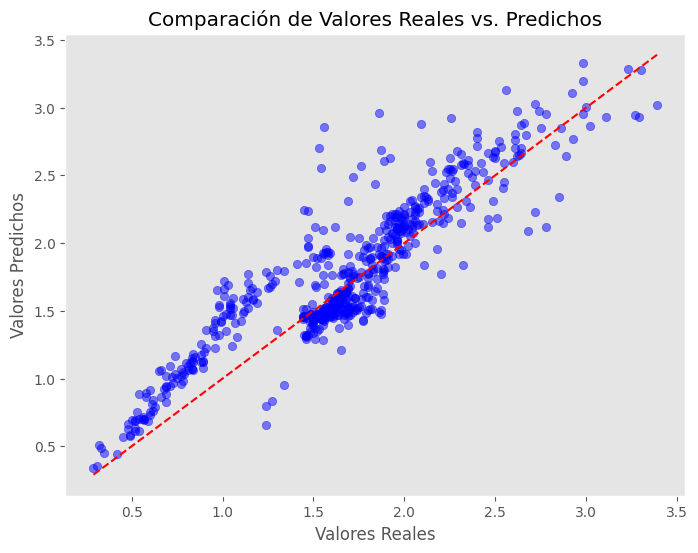

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_RF, alpha=0.5, color="blue")  # Puntos de dispersión
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Línea ideal
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación de Valores Reales vs. Predichos")
plt.grid()
plt.show()

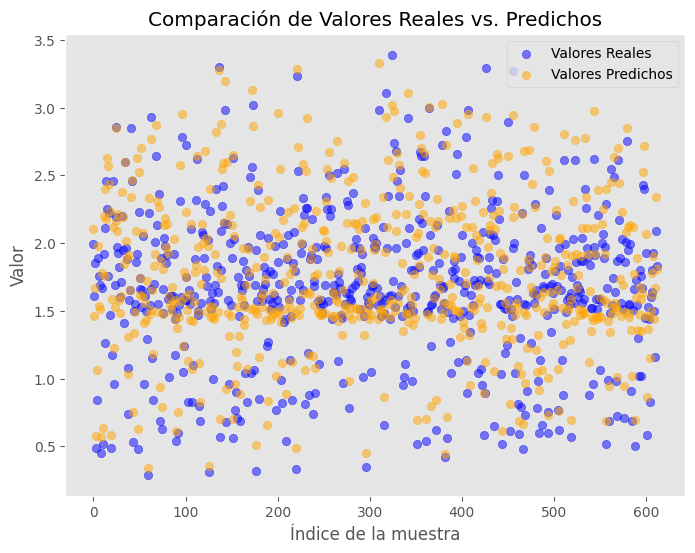

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Graficar los valores reales como puntos (azules)
plt.scatter(range(len(y_test)), y_test, alpha=0.5, color="blue", label="Valores Reales")

# Graficar los valores predichos como puntos (naranjas)
plt.scatter(range(len(y_pred_RF)), y_pred_RF, alpha=0.5, color="orange", label="Valores Predichos")

plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Comparación de Valores Reales vs. Predichos")
plt.legend()  # Agregar leyenda para diferenciar
plt.grid()
plt.show()

* Con RandomForest se puede calcular la importancia de cada atributo o variable

In [ ]:
selected_features = X_train_norm.columns.to_list()

In [ ]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': selected_features ,
              'RadomForrest': best_RF_grdregressor.feature_importances_})

Feature Relevancies


,Attributes,RadomForrest
0,tmax,0.032940
1,horaracha,0.011384
2,hrMedia,0.014474
3,altitud,0.000000
4,prec,0.019671
5,horatmin,0.011874
6,racha,0.015425
7,tmed,0.050900
8,horatmax,0.010528
9,tmin,0.036283


### 2 -AdaBoostRegressor

#### GridSearch

* Hiperparámetros

* En esta parte ajustaré los hyperparámetro de cada algorímo obtenidos previamente hasta conseguir un MAE adecuado

In [ ]:
# AdaBoost
param_dist_ADA = {
    "n_estimators": [128, 256],
    "learning_rate": [0.01, 0.05, 0.001],
    "loss": ['square', ],
    "random_state" : [seed,]
}

In [ ]:
base_estimator = DecisionTreeRegressor(max_depth=None, criterion = "absolute_error")

grid_ada = GridSearchCV(AdaBoostRegressor(base_estimator), param_grid = param_dist_ADA, cv=5)

grid_ada.fit(X = X_train_norm,y = y_train_norm)

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error')),
             param_grid={'learning_rate': [0.01, 0.05, 0.001],
                         'loss': ['square'], 'n_estimators': [128, 256],
                         'random_state': [42]})

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import cross_val_predict

best_ada = grid_ada.best_estimator_
print (best_ada)
# fit and predict
best_ada.fit( X = X_train_norm, y = y_train_norm)


AdaBoostRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error'),
                  learning_rate=0.05, loss='square', n_estimators=256,
                  random_state=42)


AdaBoostRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error'),
                  learning_rate=0.05, loss='square', n_estimators=256,
                  random_state=42)

In [ ]:
from joblib import dump, load

In [ ]:
dump(best_ada, "./drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/modelos/adaboost_model_amieva.pkl")

['./drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/modelos/adaboost_model_amieva.pkl']

In [ ]:
best_ada = load("./drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/modelos/adaboost_model_amieva.pkl")

In [ ]:
y_pred_ADA = best_ada.predict(X = X_test_norm)
y_pred_ADA = scaler_Y.inverse_transform(y_pred_ADA.reshape(-1, 1))
# Evaluar
from sklearn.metrics import mean_absolute_error
sme_ADA = mean_squared_error(y_test, y_pred_ADA)
mae_ADA = mean_absolute_error(y_test, y_pred_ADA)
r2_Ada = r2_score(y_test, y_pred_ADA)
#mae_ADA = -np.mean(scores)
print('SME', sme_ADA)
print ('MAE', mae_ADA)
print('R2', r2_Ada)

SME 0.2230577505673412
MAE 0.33612291156294805
R2 0.3003926811336538


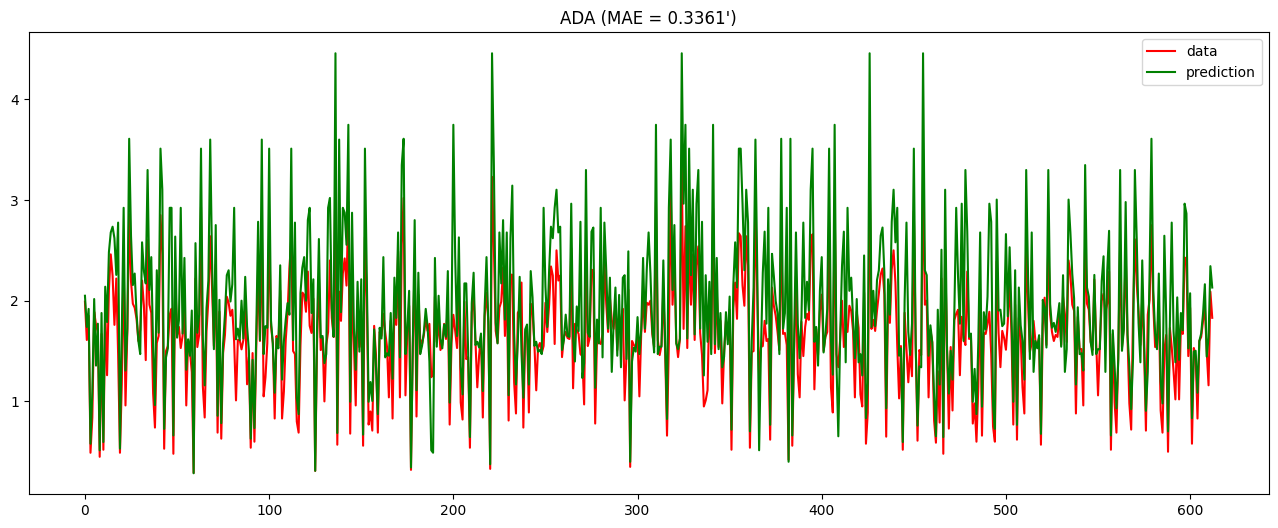

In [ ]:
# x axis for plotting
import numpy as np
plt.figure(figsize=(16, 6))
xx = np.stack([i for i in range(y_test.shape[0])])
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred_ADA, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("ADA (MAE = %6.4f')" % ( mae_ADA))

plt.show()

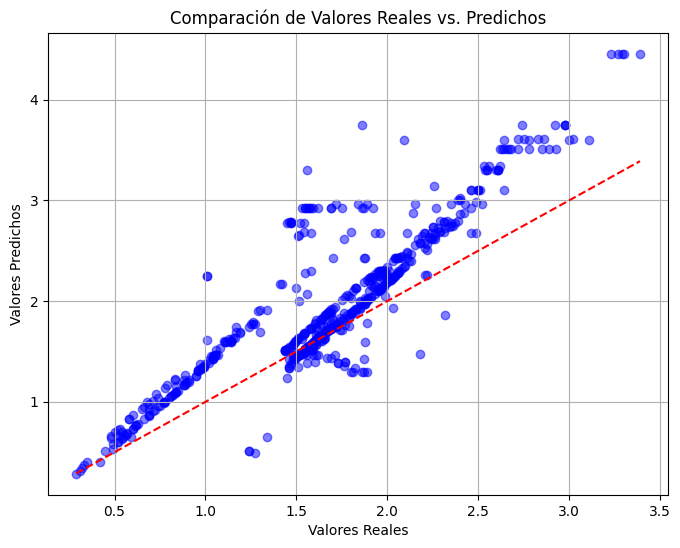

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ADA, alpha=0.5, color="blue")  # Puntos de dispersión
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Línea ideal
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación de Valores Reales vs. Predichos")
plt.grid()
plt.show()

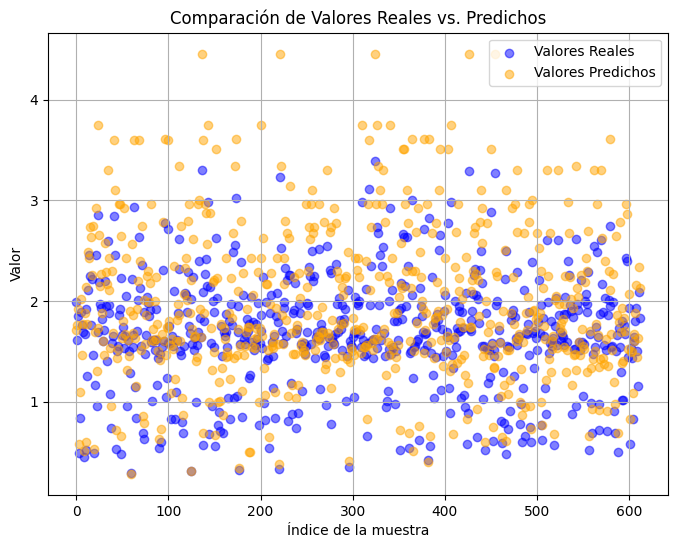

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Graficar los valores reales como puntos (azules)
plt.scatter(range(len(y_test)), y_test, alpha=0.5, color="blue", label="Valores Reales")

# Graficar los valores predichos como puntos (naranjas)
plt.scatter(range(len(y_pred_ADA)), y_pred_ADA, alpha=0.5, color="orange", label="Valores Predichos")

plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Comparación de Valores Reales vs. Predichos")
plt.legend()  # Agregar leyenda para diferenciar
plt.grid()
plt.show()

## 3-LSTM

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [7]:
#lista = [data_ami, data_cab]
data_LSTM = data_ami#pd.concat(lista, ignore_index=True)

In [8]:
variables = data_LSTM.columns.tolist()
display(variables)

['index',
 'indicativo',
 'provincia',
 'tmax',
 'horaracha',
 'hrMedia',
 'altitud',
 'prec',
 'horatmin',
 'racha',
 'tmed',
 'horatmax',
 'nombre',
 'fecha',
 'tmin',
 'velmedia',
 'dir',
 'altura_m',
 'caudal_m3s']

In [9]:
lista_variables = [
 'tmax',
 'horaracha',
 'hrMedia',
 'altitud',
 'prec',
 'horatmin',
 'racha',
 'tmed',
 'horatmax',
 'fecha',
 'tmin',
 'velmedia',
 'dir',
 'caudal_m3s',
 'altura_m']

In [10]:
data_LSTM = data_LSTM[lista_variables]

In [11]:
data_LSTM.set_index('fecha', inplace=True)

In [12]:
# Crear dataframe de ejemplo
df = data_LSTM.copy()

# Normalización
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [14]:
# Definir función para crear secuencias
def create_sequences(df, timesteps):
    X, y = [], []
    for i in range(len(df) - timesteps):
        X.append(df.iloc[i:i + timesteps, :-1].values)  # Primeras 13 variables como entrada
        y.append(df.iloc[i + timesteps, -1])           # Última variable como salida
    return np.array(X), np.array(y)

# Definir hiperparámetros
timesteps = 3
X, y = create_sequences(df_scaled, timesteps)

In [15]:
# Dividir en conjunto de entrenamiento y prueba
train_size = int(len(X) * 0.7)
X_train, X_temp = X[:train_size], X[train_size:]
y_train, y_temp = y[:train_size], y[train_size:]

In [16]:
test_size = int(len(X_temp) * 0.5)
X_val, X_test = X_temp[:test_size], X_temp[test_size:]
y_val, y_test = y_temp[:test_size], y_temp[test_size:]

In [ ]:
# Construcción del modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(timesteps, 13)),
    LSTM(50, return_sequences=False),
    
    Dense(1, activation='linear')
])
optimizer = Adam(learning_rate=5e-4) #1e-5
# Compilación del modelo
model.compile(optimizer=optimizer, loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3, 50)               │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# 3. Entrenamiento del Modelo
my_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=30,
                                         min_lr=5e-4,
                                         mode='min')
]

epochs = 500 # 209
batch_size = 32

In [31]:
# Entrenamiento
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=my_callbacks)

Epoch 1/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0210 - val_loss: 0.0083 - learning_rate: 5.0000e-04
Epoch 2/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 3/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0091 - val_loss: 0.0068 - learning_rate: 5.0000e-04
Epoch 4/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0083 - val_loss: 0.0049 - learning_rate: 5.0000e-04
Epoch 5/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0085 - val_loss: 0.0049 - learning_rate: 5.0000e-04
Epoch 6/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - val_loss: 0.0064 - learning_rate: 5.0000e-04
Epoch 7/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0083 - val_loss: 0.0053 - learning_rate: 5.0000e-04
Epoch 8/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 0.0078 - learning_rate: 5.0000e-04
Epoch 9/500
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083 - val_lo

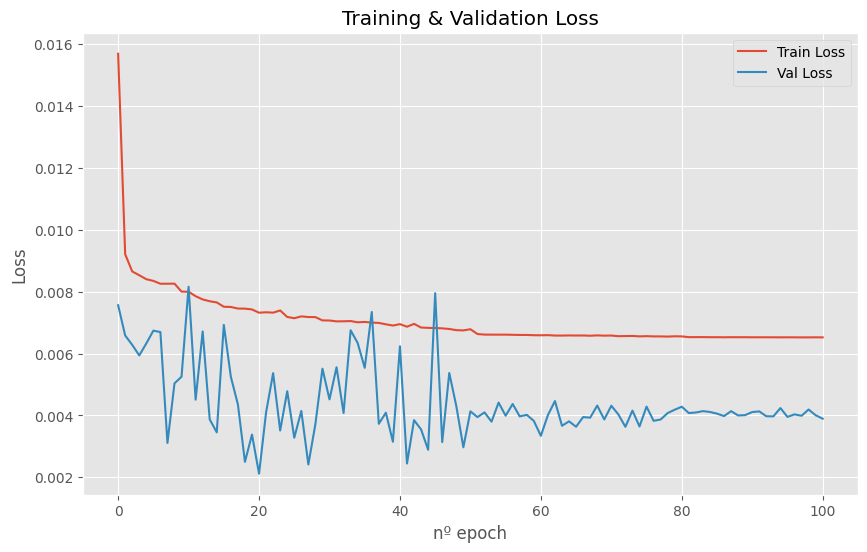

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Aplicar el estilo ggplot
plt.style.use("ggplot")

# Definir el número de épocas correctamente
epoch = len(history.history["loss"])

# Crear una figura con dos gráficos en una misma fila
fig, ax = plt.subplots(1, figsize=(10, 6))

# Pérdida (Loss)
ax.plot(np.arange(0, epoch), history.history["loss"], label="Train Loss")
ax.plot(np.arange(0, epoch), history.history["val_loss"], label="Val Loss")
ax.set_title("Training & Validation Loss")
ax.set_xlabel("nº epoch")
ax.set_ylabel("Loss")
ax.legend()

# Mostrar los gráficos
plt.show()

In [ ]:
model.save("./drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/modelos/LSTM_amieva.keras")  # Guarda en formato Keras

In [ ]:
model = keras.models.load_model("./drive/MyDrive/MASTER_BIG_DATA/14_TFM/scripts/modelos/LSTM_amieva.keras")

In [22]:
# Evaluación
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028
Test Loss: 0.0023050098679959774


In [23]:
# Predicción
y_pred = model.predict(X_test)
# Desnormalizar los datos
y_test_original = scaler.inverse_transform(np.c_[np.zeros((y_test.shape[0], 13)), y_test])[:, -1]
y_pred_original = scaler.inverse_transform(np.c_[np.zeros((y_pred.shape[0], 13)), y_pred])[:, -1]

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [24]:
# Evaluación
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")

MSE: 0.07807622356509655
MAE: 0.21195214364426868
R2 Score: 0.6642896421045488


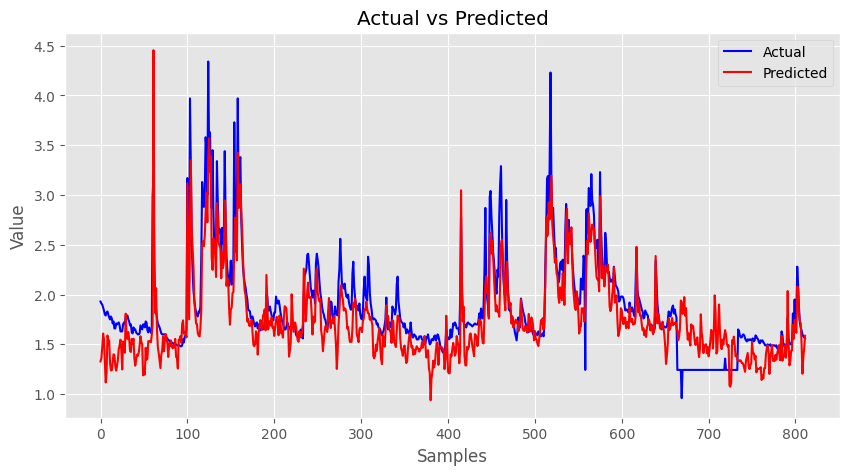

In [25]:
# Gráfica de resultados
plt.figure(figsize=(10,5))
plt.plot(y_test_original, label='Actual', color='blue')
plt.plot(y_pred_original, label='Predicted', color='red')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Value')
plt.show()

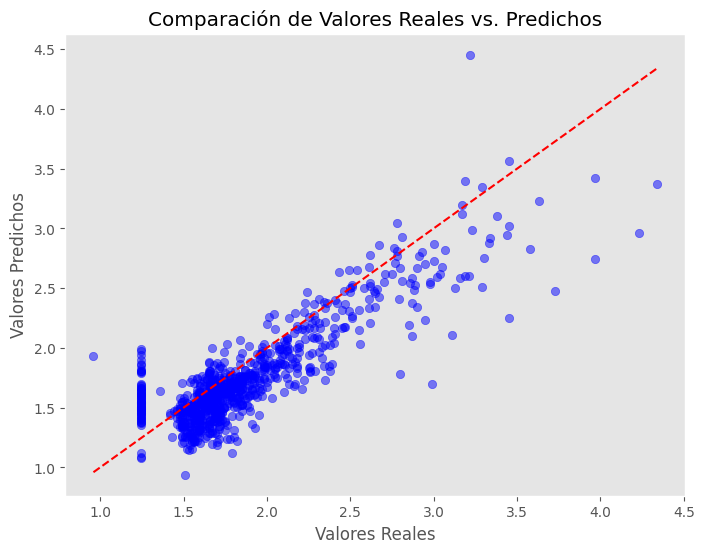

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5, color="blue")  # Puntos de dispersión
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color="red", linestyle="--")  # Línea ideal
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Comparación de Valores Reales vs. Predichos")
plt.grid()
plt.show()

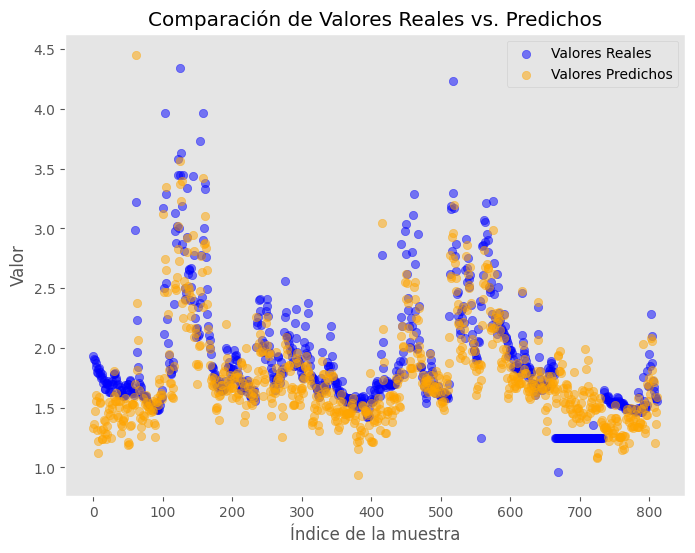

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Graficar los valores reales como puntos (azules)
plt.scatter(range(len(y_test_original)), y_test_original, alpha=0.5, color="blue", label="Valores Reales")

# Graficar los valores predichos como puntos (naranjas)
plt.scatter(range(len(y_pred_original)), y_pred_original, alpha=0.5, color="orange", label="Valores Predichos")

plt.xlabel("Índice de la muestra")
plt.ylabel("Valor")
plt.title("Comparación de Valores Reales vs. Predichos")
plt.legend()  # Agregar leyenda para diferenciar
plt.grid()
plt.show()